In this notebook we use discuss different techniques of sentiment analysis. 

## Table of Contents

* [Unsupervised Sentiment Analysis](#sentiment)
    * [Vader Sentiment Analyzer](#vader)
    * [Evaluating Vader](#evvader)
* [Supervised Sentiment Modelling](#supervised)
    * [Naive Bayes](#nb)
    * [Evaluating Naive Bayes](#evnb)
    * [LSTM](#lstm)
    * [Evaluating LSTM](#evlstm)

<a id='sentiment'></a>

### Unsupervised Sentiment Analysis

Sentiment analysis aka. opinion mining, polarity analysis is a technique to understand intent within a text. It is one of the most popular areas in NLP. We first discuss lexicon based sentiment analysis for which we use NLTK Vader sentiment analyzer.

<a id='vader'></a>
#### Vader Sentiment Analyzer

VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media. VADER uses a combination of A sentiment lexicon is a list of lexical features (e.g., words) which are generally labelled according to their semantic orientation as either positive or negative.

In [1]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer

pd.options.display.max_colwidth = -1

data = pd.read_csv('amazon_reviews_cleaned.csv') #for excel file use read_excel

In [2]:
data.head(5)

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image,clean_reviewtext
0,5.0,True,"08 22, 2013",A34A1UP40713F8,B00009W3I4,{'Style:': ' Dryer Vent'},James. Backus,I like this as a vent as well as something that will keep house warmer in winter. I sanded it and then painted it the same color as the house. Looks great.,Great product,1377129600,NaN,NaN,like vent well something keep house warm winter sand paint color house look great
1,5.0,True,"02 8, 2016",A1AHW6I678O6F2,B00009W3PA,{'Size:': ' 6-Foot'},kevin.,good item,Five Stars,1454889600,NaN,NaN,good item
2,5.0,True,"08 5, 2015",A8R48NKTGCJDQ,B00009W3PA,{'Size:': ' 6-Foot'},CDBrannom,Fit my new LG dryer perfectly.,Five Stars,1438732800,NaN,NaN,fit new lg dryer perfectly
3,5.0,True,"04 24, 2015",AR3OHHHW01A8E,B00009W3PA,{'Size:': ' 6-Foot'},Calvin E Reames,Good value for electric dryers,Perfect size,1429833600,NaN,NaN,good value electric dryer
4,5.0,True,"03 21, 2015",A2CIEGHZ7L1WWR,B00009W3PA,{'Size:': ' 6-Foot'},albert j. kong,Price and delivery was excellent.,Five Stars,1426896000,NaN,NaN,price delivery excellent


overall column is the sentiment. We convert it into int

In [3]:
data.overall = data.overall.astype(int)

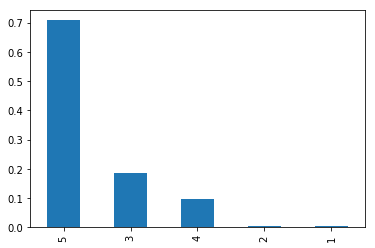

In [4]:
import matplotlib.pyplot as plt

data.overall.value_counts(normalize=True).plot.bar()
plt.show()

More than 70% of the reviews have 5 rating. Let us see how Vader evaluates these reviews

In [5]:
sample_positive_review = data[data.overall == 5].clean_reviewtext.iloc[0]
print (sample_positive_review)

like vent well something keep house warm winter sand paint color house look great


In [6]:
sid = SentimentIntensityAnalyzer()

In [7]:
sid.polarity_scores(sample_positive_review)

{'compound': 0.8625, 'neg': 0.0, 'neu': 0.485, 'pos': 0.515}

The overall or compound score is 0.8625, which can be think of as a very positive sentiment. Now let us check some neutral and negative ratings

In [8]:
sample_neutral_review = data[data.overall == 3].clean_reviewtext.iloc[0]
print (sample_neutral_review)

sid.polarity_scores(sample_neutral_review)

connect match modidify work


{'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0}

In [9]:
sample_negative_review = data[data.overall == 1].clean_reviewtext.iloc[0]
print (sample_negative_review)

sid.polarity_scores(sample_negative_review)

careful NewAir stand product NewAir break within first 4 hour use manufacturer cover item warranty case actually think buy NewAir product think twice NewAir Sales date Fri Nov 14 2014 11 03 subject icemaker return Susan Ferguson hi Susan manufacturer warranty void unit purchase private seller consent sell product reason ask copy receipt upon request warranty claim valid authorize dealer proceed warranty work also list authorize dealer web site customer use stand behind product however item purchase private seller purchaser run risk item use open box refurbish scratch dent one year limited manufacturer warranty valid new item sell authorize online dealer unfortunate see situation however need contact seller item replacement refund great day Mireya Customer Support NewAir 3419 East Chapman Ave 190 Orange CA 92869 Ph 855 963 9247 Em fb facebook com NewAirUSA Twitter NewAirUSA Pinterest pinterest com NewAirUSA Instagram NewAirUSA web make awesome Thu Nov 13 2014 7 59 PM Susan Ferguson writ

{'compound': 0.9916, 'neg': 0.051, 'neu': 0.786, 'pos': 0.163}

In [10]:
sample_negative_review = data[data.overall == 1].clean_reviewtext.iloc[1]
print (sample_negative_review)

sid.polarity_scores(sample_negative_review)

would give less 1 star possible DONT buy product ice machine stop work four hour use first time notify New Air state would honor one year warranty authorize dealer sell buy product Amazon never even think would cross check purchase manufacturer NewAir stand product use method get honor warranty 200 piece junk never buy another NewAir product


{'compound': 0.7096, 'neg': 0.035, 'neu': 0.835, 'pos': 0.13}

We see Vader severly fail to detect negative sentiments. It could be due to that, in e-commerce website people often give bad rating because of their bad experience and in the reviews they tend to put more words about their distress. These words may not be present in the lexicons used to built Vader.

Under these scenarios supervised methods can perform much better. Before going there, let us classify all our reviews and check for the accuracy.

In [11]:
def get_sentiment_score(x):
    sid = SentimentIntensityAnalyzer()
    return sid.polarity_scores(x)['compound']

In [12]:
data = data.dropna(subset=['clean_reviewtext'])

data['real_sentiment_score'] = data.clean_reviewtext.apply(get_sentiment_score)

As the sentiment scores are real valued, we quantize these into discrete integers between 1-5

In [13]:
def quantize(x):
    if x < -0.6 :
        return 1
    elif x >= -0.6 and x < -0.2:
        return 2
    elif x >= -0.2 and x < 0.2:
        return 3
    elif x >= 0.2 and x < 0.6:
        return 4
    else:
        return 5

In [14]:
data['predicted_sentiment'] = data.real_sentiment_score.apply(quantize) #pd.qcut(data.real_sentiment_score, 5, labels=False) + 1

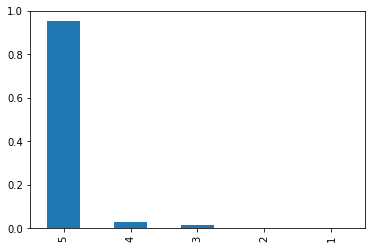

In [15]:
data.predicted_sentiment.value_counts(normalize=True).plot.bar()
plt.show()

<a id='evvader'></a>

#### Evaluating Vader

Let us check the overall accuracy. As the actual sentiment labels are not even distributed, F1 score is a better evaluation metric than multi class accuracy score.

In [23]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

print (accuracy_score(data.overall,data.predicted_sentiment))
print (f1_score(data.overall,data.predicted_sentiment,average='macro'))
print (confusion_matrix(data.overall,data.predicted_sentiment))

0.6747359154929577
0.19290057104467584
[[   0    1    3    0    5]
 [   0    1    9    1    2]
 [   0    0    2    5  414]
 [   0    0    4    3  215]
 [   1    1   19   59 1527]]


We can observe how Vader is skewed towards positive sentiment

<a id='supervised'></a>

### Supervised methods for Sentiment Analysis

<a id='nb'></a>

#### Naive Bayes

We will start with a very basic technique Naive Bayes. In machine learning, naïve Bayes classifiers are a family of simple "probabilistic classifiers" based on applying Bayes' theorem with strong (naïve) independence assumptions between the features.

<img src=https://uc-r.github.io/public/images/analytics/naive_bayes/naive_bayes_icon.png>

In our context, we will take tf-idf vectors are our features and sentiment class as our target

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vector = TfidfVectorizer(lowercase=True, #this will convert all the tokens into lower case
                         stop_words='english', #remove english stopwords from vocabulary. if we need the stopwords this value should be None
                         analyzer='word', #tokens should be words. we can also use char for character tokens
                         max_features=50000, #maximum vocabulary size to restrict too many features
                         min_df = 10,
                         max_df = .6
                        )

tfidf_vectorized_corpus = tfidf_vector.fit_transform(data.clean_reviewtext)

In [17]:
from sklearn.naive_bayes import MultinomialNB

In [18]:
nb = MultinomialNB()

For evaluation, we use cross validation. i.e. train on a part of data and testing on the remaining. We will use 5-fold cross validation. 

<img src=https://miro.medium.com/max/1710/1*rgba1BIOUys7wQcXcL4U5A.png width="500">

In [19]:
from sklearn.model_selection import cross_val_predict, cross_val_score

In [20]:
sentiment_predicted_nb = cross_val_predict(X=tfidf_vectorized_corpus,y=data.overall,cv=5,estimator=nb)

In [21]:
data['sentiment_predicted_nb'] = sentiment_predicted_nb

<a id='evnb'></a>

#### Evaluating Naive Bayes

In [24]:
print (accuracy_score(data.overall,data.sentiment_predicted_nb))
print (f1_score(data.overall,data.sentiment_predicted_nb,average='macro'))
print (confusion_matrix(data.overall,data.sentiment_predicted_nb))

0.9757922535211268
0.5833512796211996
[[   0    0    0    0    9]
 [   0    0    0    4    9]
 [   0    0  412    0    9]
 [   0    0    0  206   16]
 [   0    0    7    1 1599]]


c:\users\asengup6\softwares\anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Naive Bayes is able to almost perfectly classify sentiment classes - 3 , 4 and 5. We will now use some deep learning based model.

<a id='lstm'></a>

#### LSTM for Sentiment Classification

Long Short Term Memory networks – usually just called “LSTMs” – are a special kind of RNN (recurrent neural network), capable of learning long-term dependencies. RNNs are useful when we have a sequential data like text. As mentioned in https://colah.github.io/posts/2015-08-Understanding-LSTMs/

"Humans don’t start their thinking from scratch every second. As you read this essay, you understand each word based on your understanding of previous words. You don’t throw everything away and start thinking from scratch again. Your thoughts have persistence."

LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behavior, not something they struggle to learn.

<img src=http://dprogrammer.org/wp-content/uploads/2019/04/RNN-vs-LSTM-vs-GRU-1024x308.png>

A typical neural network for text classification looks like - 

1. An embedding layer to learn embedding for each word in each text
2. LSTM/GRU/RNN layer consisting multiple cells to identify hidden semantics for each word given previous words. Bidirectional cells are used to use hidden information from both previous and after words.
3. Dense layer to consolidate all the information at the text level
4. Output layer (softmax/sigmoid) to get final output

The parameters of the model are learned by back propagation algorithm where
1. parameter weights are initialized randomly
2. Calculate the overall loss
3. Calculate gradient for each parameter and update using gradient descent

By doing so, we can update all the parameters of the model that minimizes the loss. (mean squared error for regression problem, cross entropy for classification etc.)

<img src=https://miro.medium.com/max/1201/1*VymEfQTf30evUczsTBiz4g.png width=400>


In [24]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import load_model

Using TensorFlow backend.


Before feeding the data into NN, we need to tokenize the data and make all the texts of same length. We pass max_len as the maximum length of the text to be passed in the NN. If a text has < max_len number of words, we pad with blank word. For longer texts we will restrict it to max_len.

In [25]:
max_fatures = 50000
max_len = 100

In [26]:
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data.clean_reviewtext.values)
X = tokenizer.texts_to_sequences(data.clean_reviewtext.values)
X = pad_sequences(X,maxlen=100)

In [27]:
word_index = tokenizer.word_index

In [28]:
print (X.shape)

(2272, 100)


In [29]:
X[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,  56,   1,  21, 168,  23,
        15, 947, 948, 949, 950, 951,  15, 262,  49])

In [30]:
data.clean_reviewtext.iloc[0]

'like vent well something keep house warm winter sand paint color house look great'

in the padded input, we see 0 padding to make the text of 100 length.

In [31]:
embed_dim = 100 #dimension of the embedding
lstm_out = 196 #dimension of the lstm output 
n_output = data.overall.nunique() #number of possible outputs

In neural network we can learn the word embeddings from scratch. However, that increases the runtime which we can skip by using pretrained models like - GloVe or, Word2Vec. As, the pretrained models are trained on large corpus, it is wise to use those embeddings and save lot of time and effort.

In [32]:
from tqdm import tqdm
import numpy as np

embeddings_index = {}
f = open('glove.6B.100d.txt','r',encoding='utf8')
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

400000it [00:32, 12254.83it/s]

Found 400000 word vectors.


In [33]:
embedding_matrix = np.zeros((len(word_index) + 1, embed_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [34]:
import tensorflow as tf
import keras.backend as K

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    # tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    #f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [35]:
def get_model():
    model = Sequential()
    model.add(Embedding(len(word_index) + 1, embed_dim,input_length = X.shape[1], weights=[embedding_matrix], trainable=False))
    model.add(SpatialDropout1D(0.4))
    model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(n_output,activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy',f1])
    #print(model.summary())
    return model

In [36]:
model = get_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          106400    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 100, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               232848    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 985       
Total params: 340,233
Trainable params: 233,833
Non-trainable params: 106,400
_________________________________________________________________


For NN we can not directly call cross_val_predict. We have to iteratively run it.

In [37]:
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau 

In [38]:
y = pd.get_dummies(data.overall).values

In [39]:
batch_size = 32
n_epochs = 10

In [94]:
iter = 0
cross_val_predict_nn = np.zeros(X.shape[0])
all_history = {}

for train_index, test_index in StratifiedKFold(n_splits=5).split(X,data.overall.values):
    iter += 1
    
    print ("Iteration {}".format(iter))
    
    train_x = X[train_index]
    train_y = y[train_index]
    val_x = X[test_index]
    val_y = y[test_index]
    
    print (train_x.shape, train_y.shape, val_x.shape, val_y.shape)
    model = get_model()
    early = EarlyStopping(monitor='val_f1', min_delta=0, patience=3, verbose=0, mode='max', baseline=None, restore_best_weights=False)
    lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0.000001)
    checkpointer = ModelCheckpoint(monitor='val_f1',filepath='weights{}.hdf5'.format(iter), mode='max',verbose=1, save_best_only=True)
    
    history = model.fit(train_x, train_y, epochs = n_epochs, batch_size=batch_size, verbose = 2, validation_data=(val_x,val_y), callbacks=[early,lr,checkpointer])
    all_history[iter] = history
    
    model = load_model('weights1.hdf5',custom_objects={'f1':f1})
    
    cross_val_predict_nn[test_index] = model.predict(val_x).argmax(axis=1) + np.ones(val_x.shape[0])

Iteration 1
(1815, 100) (1815, 5) (457, 100) (457, 5)
Train on 1815 samples, validate on 457 samples
Epoch 1/10
 - 24s - loss: 0.4414 - accuracy: 0.8683 - f1: 0.4037 - val_loss: 0.3315 - val_accuracy: 0.9409 - val_f1: 0.5102

Epoch 00001: val_f1 improved from -inf to 0.51023, saving model to weights1.hdf5
Epoch 2/10
 - 23s - loss: 0.0789 - accuracy: 0.9868 - f1: 0.5952 - val_loss: 0.3307 - val_accuracy: 0.9409 - val_f1: 0.5118

Epoch 00002: val_f1 improved from 0.51023 to 0.51177, saving model to weights1.hdf5
Epoch 3/10
 - 19s - loss: 0.0522 - accuracy: 0.9879 - f1: 0.5957 - val_loss: 0.3051 - val_accuracy: 0.9409 - val_f1: 0.5113

Epoch 00003: val_f1 did not improve from 0.51177
Epoch 4/10
 - 18s - loss: 0.0487 - accuracy: 0.9884 - f1: 0.5930 - val_loss: 0.3428 - val_accuracy: 0.9344 - val_f1: 0.5109

Epoch 00004: val_f1 did not improve from 0.51177
Epoch 5/10
 - 19s - loss: 0.0378 - accuracy: 0.9912 - f1: 0.5948 - val_loss: 0.3332 - val_accuracy: 0.9365 - val_f1: 0.5175

Epoch 00005


Epoch 00004: val_f1 did not improve from 0.49889
Epoch 5/10
 - 19s - loss: 0.0621 - accuracy: 0.9813 - f1: 0.5735 - val_loss: 0.1567 - val_accuracy: 0.9690 - val_f1: 0.4912

Epoch 00005: val_f1 did not improve from 0.49889
Epoch 6/10
 - 19s - loss: 0.0482 - accuracy: 0.9846 - f1: 0.6027 - val_loss: 0.1521 - val_accuracy: 0.9646 - val_f1: 0.4883

Epoch 00006: val_f1 did not improve from 0.49889


<a id='evlstm'></a>

#### Evaluating LSTM

In [95]:
print (accuracy_score(data.overall,cross_val_predict_nn))
print (f1_score(data.overall,cross_val_predict_nn,average='macro'))
print (confusion_matrix(data.overall,cross_val_predict_nn))

0.980193661971831
0.8510651399577986
[[   6    0    2    0    1]
 [   0    6    0    0    7]
 [   0    0  412    0    9]
 [   1    0    0  207   14]
 [   1    0    1    9 1596]]


In just 10 epochs, we can see a drastic improvement over previous models. One can change the type of RNN cell, increase model depth, number of cell, even different architecture. Before finishing off our tutorial, let us see how the model optimized the loss function.

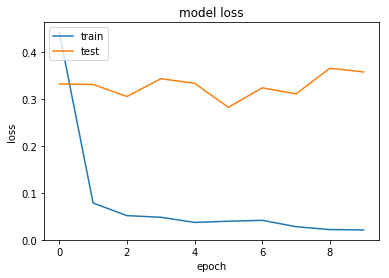

In [100]:
import matplotlib.pyplot as plt

plt.plot(all_history[1].history['loss'])
plt.plot(all_history[1].history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

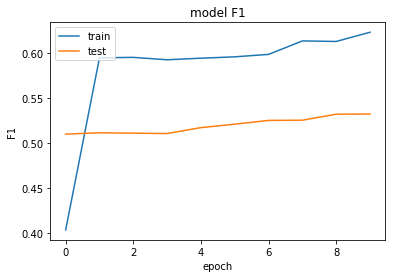

In [101]:
plt.plot(all_history[1].history['f1'])
plt.plot(all_history[1].history['val_f1'])
plt.title('model F1')
plt.ylabel('F1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

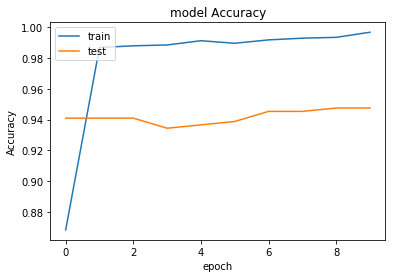

In [103]:
plt.plot(all_history[1].history['accuracy'])
plt.plot(all_history[1].history['val_accuracy'])
plt.title('model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Pytorch LSTM

Same exercise we do using Pytorch library. Pytorch is developed by Facebook and has recently surpassed the popularity of tensorflow due to its design and efficiency. This subsection can be skipped.

In [122]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

torch.manual_seed(1)

In [105]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [213]:
class LSTMClassifier(nn.Module):
    def __init__(self, embedding_matrix, seq_len, hidden_size, n_layers, num_class, non_trainable=True):
        super().__init__()
        vocab_size = embedding_matrix.shape[0]
        embed_dim = embedding_matrix.shape[1]
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.dropout=nn.Dropout(0.3)
        
        self.embedding = nn.Embedding(vocab_size,embed_dim)
        self.embedding.load_state_dict({'weight': torch.LongTensor(embedding_matrix)})
        if non_trainable:
            self.embedding.weight.requires_grad = False
            
        self.lstm = nn.LSTM(embed_dim, hidden_size, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size*seq_len, num_class)

    def forward(self, text, hidden):
        batch_size = text.shape[0]
        out, hidden = self.lstm(self.embedding(text),hidden)
        out = out.contiguous().view(batch_size,-1)
        return self.fc(out), hidden
    
    def init_hidden(self, batch_size):
        """Initialize Hidden STATE"""
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_size).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_size).zero_().to(device))
        
        return hidden

In [216]:
model = LSTMClassifier(embedding_matrix,max_len,lstm_out,1,n_output)
print (model.parameters)
model = model.to(device)

<bound method Module.parameters of LSTMClassifier(
  (dropout): Dropout(p=0.3, inplace=False)
  (embedding): Embedding(1064, 100)
  (lstm): LSTM(100, 196, batch_first=True)
  (fc): Linear(in_features=19600, out_features=5, bias=True)
)>


In [208]:
?nn.LSTM

In [211]:
n_layers = 1

In [232]:
iter = 0
cross_val_predict_nn = np.zeros(X.shape[0])
all_history = {}

for train_index, test_index in StratifiedKFold(n_splits=5).split(X,data.overall.values):
    iter += 1
    
    all_history[iter] = {}
    
    print ("******************* Iteration {} **************".format(iter))
    print ()
    
    train_x = X[train_index]
    train_y = y[train_index]
    val_x = X[test_index]
    val_y = y[test_index]
    
    train_data = TensorDataset(torch.LongTensor(train_x), torch.LongTensor(train_y))
    val_data = TensorDataset(torch.LongTensor(val_x), torch.LongTensor(val_y))

    #dataloader
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

    
    model = LSTMClassifier(embedding_matrix,max_len,lstm_out,n_layers, n_output)
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True, min_lr=.000001,mode='max')
    criterion = criterion.to(device)

    all_history[iter][-1] = {'epoch_train_loss':0,'epoch_train_acc':0,'epoch_train_f1':0,
                               'epoch_val_loss':0,'epoch_val_acc':0,'epoch_val_f1':0}
    
    # train for some number of epochs
    for e in range(n_epochs):
        
        epoch_train_loss = 0
        epoch_train_acc = 0
        epoch_train_f1 = 0
        epoch_val_loss = 0
        epoch_val_acc = 0
        epoch_val_f1 = 0
        
        running_train_loss = 0.0
        running_train_corrects = 0
        running_train_f1 = 0
        counter = 0
        
        model.train()

        # batch loop
        for inputs, labels in train_loader:
            counter += 1

            # initialize hidden state
            h = model.init_hidden(inputs.shape[0])
        
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            h = tuple([each.data for each in h])

            # zero accumulated gradients
            model.zero_grad()

            # get the output from the model
            output, h = model(inputs, h)

            # calculate the loss and perform backprop
            #loss = criterion(output.squeeze(), labels.long())
            loss = criterion(output, torch.max(labels, 1)[1])
            
            loss.backward()
            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            #nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()

            _, preds = torch.max(output, 1)
            
            running_train_loss += loss.item() * inputs.size(0)
            running_train_corrects += torch.sum(preds == torch.argmax(labels.data,1))
            running_train_f1 += f1_score(np.array(labels.data.to('cpu')).argmax(1), np.array(preds.data.to('cpu')), average='macro')
            
        epoch_train_loss = running_train_loss / train_x.shape[0]
        epoch_train_acc = running_train_corrects.double() / train_x.shape[0]
        epoch_train_f1 = running_train_f1 / counter
        
        model.eval()

        running_val_loss = 0.0
        running_val_corrects = 0
        running_val_f1 = 0
        counter = 0

        # batch loop
        for inputs, labels in val_loader:
            counter += 1

            # initialize hidden state
            h = model.init_hidden(inputs.shape[0])
        
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            # h = tuple([each.data for each in h])

            # get the output from the model
            output, h = model(inputs, h)

            # calculate the loss and perform backprop
            #loss = criterion(output.squeeze(), labels.long())
            loss = criterion(output, torch.max(labels, 1)[1])
            
            _, preds = torch.max(output, 1)

            running_val_loss += loss.item() * inputs.size(0)
            running_val_corrects += torch.sum(preds == torch.argmax(labels.data,1))
            running_val_f1 += f1_score(np.array(labels.data.to('cpu')).argmax(1), np.array(preds.data.to('cpu')), average='macro')


        epoch_val_loss = running_val_loss / val_x.shape[0]
        epoch_val_acc = running_val_corrects.double() / val_x.shape[0]
        epoch_val_f1 = running_val_f1 / counter
    
        all_history[iter][e] = {'epoch_train_loss':epoch_train_loss,'epoch_train_acc':epoch_train_acc,'epoch_train_f1':epoch_train_f1,
                               'epoch_val_loss':epoch_val_loss,'epoch_val_acc':epoch_val_acc,'epoch_val_f1':epoch_val_f1}
        
        scheduler.step(epoch_val_f1)
        
        print ("Epoch {}: train loss {:.3f}, train acc {:.3f}, train f1 {:.3f}, val loss {:.3f}, val acc {:.3f}, val f1 {:.3f}".format(e, epoch_train_loss,
                epoch_train_acc, epoch_train_f1, epoch_val_loss, epoch_val_acc, epoch_val_f1))
        print()
        
        if epoch_val_f1 > all_history[iter][e-1]['epoch_val_f1']:
            torch.save(model,"model{}_torch.hdf5".format(iter))
            print ("saving new checkpoint in model{}_torch.hdf5".format(iter))
    output, _ = model(torch.LongTensor(val_x),model.init_hidden(val_x.shape[0]))
    cross_val_predict_nn[test_index] = np.array(output.data.to('cpu')).argmax(axis=1) + np.ones(val_x.shape[0])       

******************* Iteration 1 **************



c:\users\asengup6\softwares\anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\asengup6\softwares\anaconda\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Epoch 0: train loss 0.195, train acc 0.950, train f1 0.850, val loss 0.222, val acc 0.943, val f1 0.850

saving new checkpoint in model1_torch.hdf5


c:\users\asengup6\softwares\anaconda\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type LSTMClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch 1: train loss 0.035, train acc 0.993, train f1 0.954, val loss 0.246, val acc 0.921, val f1 0.706

Epoch 2: train loss 0.029, train acc 0.993, train f1 0.951, val loss 0.236, val acc 0.945, val f1 0.854

saving new checkpoint in model1_torch.hdf5
Epoch 3: train loss 0.029, train acc 0.993, train f1 0.958, val loss 0.218, val acc 0.945, val f1 0.882

saving new checkpoint in model1_torch.hdf5
Epoch 4: train loss 0.024, train acc 0.993, train f1 0.953, val loss 0.236, val acc 0.945, val f1 0.838

Epoch 5: train loss 0.021, train acc 0.994, train f1 0.965, val loss 0.235, val acc 0.945, val f1 0.876

saving new checkpoint in model1_torch.hdf5
Epoch 6: train loss 0.020, train acc 0.994, train f1 0.965, val loss 0.260, val acc 0.945, val f1 0.863

Epoch 7: train loss 0.016, train acc 0.996, train f1 0.978, val loss 0.311, val acc 0.945, val f1 0.883

saving new checkpoint in model1_torch.hdf5
Epoch 8: train loss 0.014, train acc 0.997, train f1 0.984, val loss 0.277, val acc 0.945, va

In [233]:
print (accuracy_score(data.overall,cross_val_predict_nn))
print (f1_score(data.overall,cross_val_predict_nn,average='macro'))
print (confusion_matrix(data.overall,cross_val_predict_nn))

0.9806338028169014
0.8647741291251725
[[   7    0    0    0    2]
 [   0    5    0    0    8]
 [   0    0  412    0    9]
 [   0    0    0  206   16]
 [   0    1    2    6 1598]]
